Tworzymy pierwszy syntetyczne zbiory

In [1]:
import sklearn.model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import pandas as pd
import time


index = 254460
seed = index
n_samples = 2560


syn1_x, syn1_t = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=seed)
syn1_train_x, syn1_test_x, syn1_train_t, syn1_test_t = train_test_split(syn1_x, syn1_t, test_size=.2, random_state=seed)
scaler = preprocessing.MinMaxScaler()
syn1_train_x = scaler.fit_transform(syn1_train_x)
syn1_test_x = scaler.fit_transform(syn1_test_x)
syn1_train_t = np.array([-1 if t == 0 else t for t in syn1_train_t])
syn1_test_t = np.array([-1 if t == 0 else t for t in syn1_test_t])
syn1_test_x_k1 = syn1_test_x[syn1_test_t == 1]
syn1_test_x_k2 = syn1_test_x[syn1_test_t == -1]


Tworzymy macierz X dla zbioru testowego

In [2]:
num_rows = syn1_test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, syn1_test_x))

Klasyfikacji Sklearn

In [3]:
start = time.time()
for _ in range(100):
    clf = RidgeClassifier(alpha=1.0).fit(syn1_train_x, syn1_train_t)
end = time.time()
print(f"Czas obliczeń implementacji Sklearn = {end - start}")
syn1_test_y = clf.predict(syn1_test_x)
b = clf.intercept_
A_S = -clf.coef_[0][0]/clf.coef_[0][1]
B_S = -b/clf.coef_[0][1]
xs_S = np.array([0, 1])
ys_S = xs_S*A_S+B_S
teta_S = [clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]]
result_S = X_test@teta_S
syn1_test_y_S = [-1 if res <= 0 else 1 for res in result_S]

Czas obliczeń implementacji Sklearn = 0.10903263092041016


Klasyfikacja analityczna

In [4]:
ALFA = 1.0

num_rows = syn1_train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, syn1_train_x))
d = X.shape[1]
start = time.time()
for _ in range(100):
    A = ALFA*np.identity(d)
    teta_A = np.linalg.inv(X.T@X+A)@X.T@syn1_train_t
end = time.time()
print(f"Czas obliczeń implementacji analityczna = {end - start}")
A_A = -teta_A[1]/teta_A[2]
B_A = -teta_A[0]/ teta_A[2]
xs_A = np.array([0, 1])
ys_A = xs_A*A_A+B_A
result_A = X_test@teta_A
syn1_test_y_A = [-1 if res <= 0 else 1 for res in result_A]

Czas obliczeń implementacji analityczna = 0.0066378116607666016


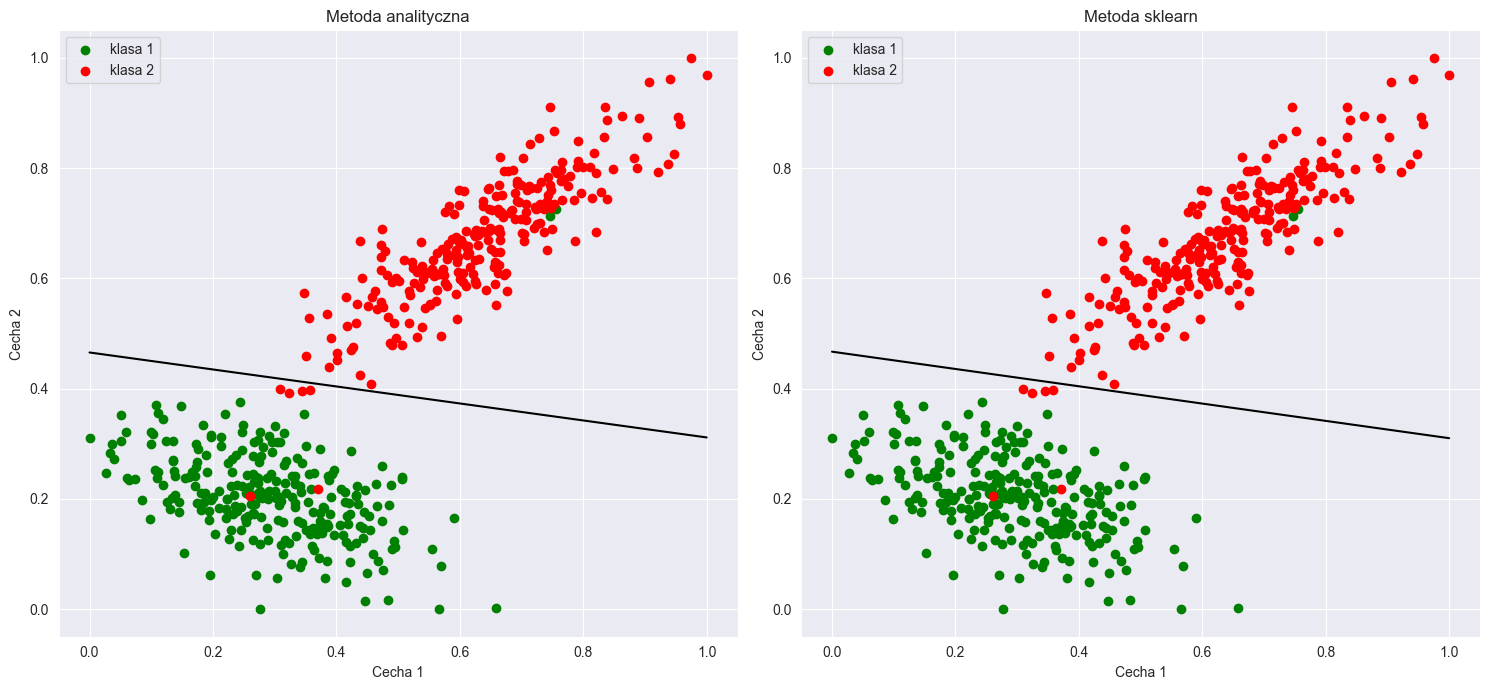

In [5]:
import seaborn as sns
sns.set_style("darkgrid")


fig, axs = plt.subplots(1, 2, figsize=(15, 7))
ax = axs[0]
ax.scatter(syn1_test_x_k1[:,0], syn1_test_x_k1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_k2[:,0], syn1_test_x_k2[:,1], c = "r", label="klasa 2")
ax.set_title("Metoda analityczna")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
ax.plot(xs_A, ys_A, c="black")

ax = axs[1]
ax.scatter(syn1_test_x_k1[:,0], syn1_test_x_k1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_k2[:,0], syn1_test_x_k2[:,1], c = "r", label="klasa 2")
ax.set_title("Metoda sklearn")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
ax.plot(xs_S, ys_S, c="black")
fig.tight_layout()

Macierz pomyłek sklearn

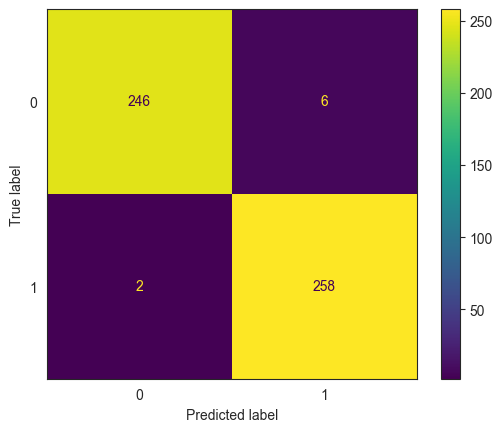

In [6]:
sns.set_style("white")
cm_S = confusion_matrix(syn1_test_t, syn1_test_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

Macierz pomyłek analityczna

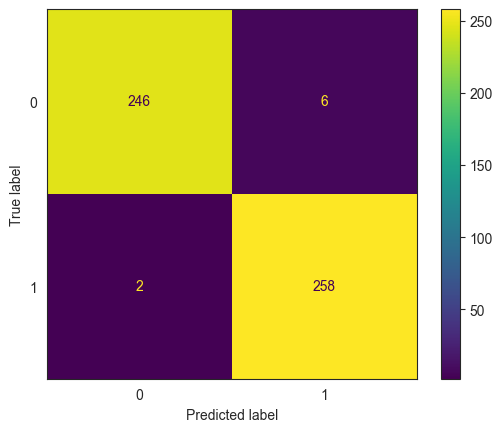

In [7]:
cm_A = confusion_matrix(syn1_test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [8]:
TP = cm_S[1, 1]
FN = cm_S[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość sklearn {sensitivity:.2f}")

TP = cm_A[1, 1]
FN = cm_A[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość analityczna {sensitivity:.2f}")

TN = cm_S[0, 0]
FP = cm_S[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość sklearn {specificity:.2f}")

TN = cm_A[0, 0]
FP = cm_A[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość analityczna {specificity:.2f}")

Czułość sklearn 0.99
Czułość analityczna 0.99
Swoistość sklearn 0.98
Swoistość analityczna 0.98


Krzywa ROC sklearn

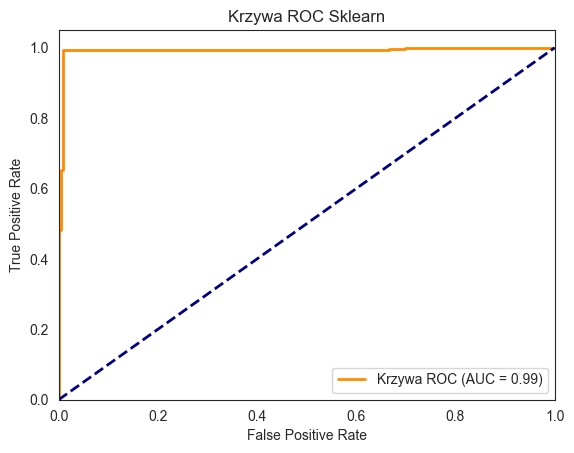

In [9]:
fpr, tpr, thresholds = roc_curve(syn1_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC analityczna

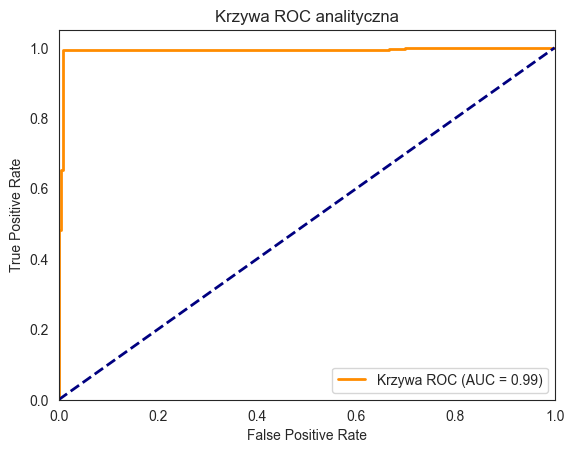

In [10]:
fpr, tpr, thresholds = roc_curve(syn1_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC analityczna')
plt.legend(loc="lower right")
plt.show()

Zaimplementowana metoda analityczna oraz gotowe rozwiązanie Sklearn generują identyczne wyniki natomiast rozwiązanie analityczne jest znacznie szybsze.\
Dla przeprowadzonych 100 treningów wynik gotowego rozwiązania to 0.10903s natomiast rozwiązania analitycznego tylko 0.00663s

Tworzymy drugi syntetyczne zbiory

In [11]:
from sklearn.datasets import make_moons

syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed)
syn2_train_x, syn2_test_x, syn2_train_t, syn2_test_t = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)
syn2_test_x_k1 = syn2_test_x[syn2_test_t == 0]
syn2_test_x_k2 = syn2_test_x[syn2_test_t == 1]
syn2_train_t = [-1 if t == 0 else t for t in syn2_train_t]
syn2_test_t = [-1 if t == 0 else t for t in syn2_test_t]

Klasyfikacji Sklearn (wielomian 3 stopnia)

Czas obliczeń implementacji Sklearn = 0.14766359329223633


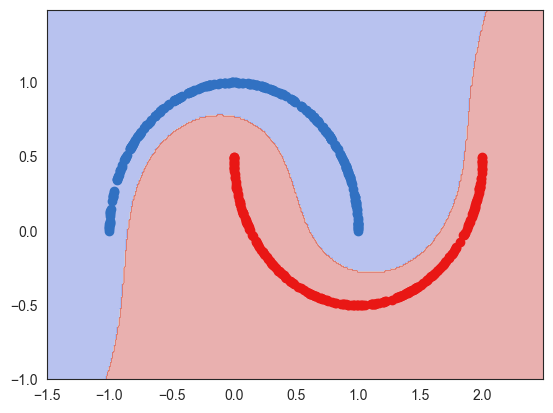

In [12]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_S = poly.fit_transform(syn2_train_x)
X_poly_test_S = poly.fit_transform(syn2_test_x)
start = time.time()
for _ in range(100):
    clf = RidgeClassifier(alpha=1.0).fit(X_poly_S, syn2_train_t)
end = time.time()
print(f"Czas obliczeń implementacji Sklearn = {end - start}")
syn2_test_y_S = clf.predict(X_poly_test_S)
result_S = clf.decision_function(X_poly_test_S)
xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.01),
                     np.arange(-1.0, 1.5, 0.01))
Z = poly.transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_k1[:,0], syn2_test_x_k1[:,1])
plt.scatter(syn2_test_x_k2[:,0], syn2_test_x_k2[:,1], c="r")
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.show()
syn1_test_y_S = clf.predict(X_poly_test_S)

Klasyfikacji analityczna (wielomian 3 stopnia)

Czas obliczeń implementacji analitycznej = 0.028490304946899414


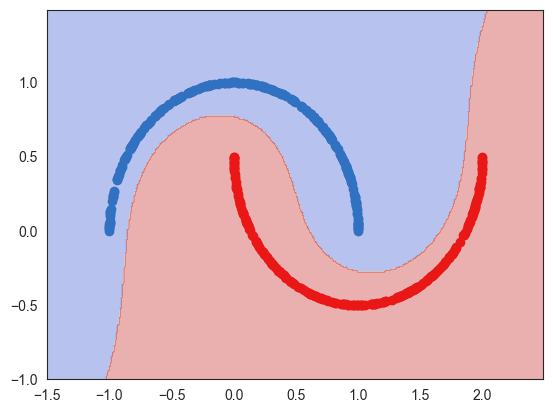

In [13]:
ALFA = 1.0


poly = PolynomialFeatures(degree=3, include_bias=True)
X = poly.fit_transform(syn2_train_x)
X_test = poly.fit_transform(syn2_test_x)
d = X.shape[1]
start = time.time()
for _ in range(100):
    A = ALFA*np.identity(d)
    teta_A = np.linalg.inv(X.T@X+A)@X.T@syn2_train_t
end = time.time()
print(f"Czas obliczeń implementacji analitycznej = {end - start}")
result_A = X_test@teta_A
syn2_test_y_A = [-1 if res <= 0 else 1 for res in result_A]
xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.01),
                     np.arange(-1.0, 1.5, 0.01))
Z = poly.transform(np.c_[xx.ravel(), yy.ravel()])
Z_P = Z@teta_A
Z = np.array([-1 if res <= 0 else 1 for res in Z_P])
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_k1[:,0], syn2_test_x_k1[:,1])
plt.scatter(syn2_test_x_k2[:,0], syn2_test_x_k2[:,1], c="r")
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.show()

Macierz pomyłek sklearn

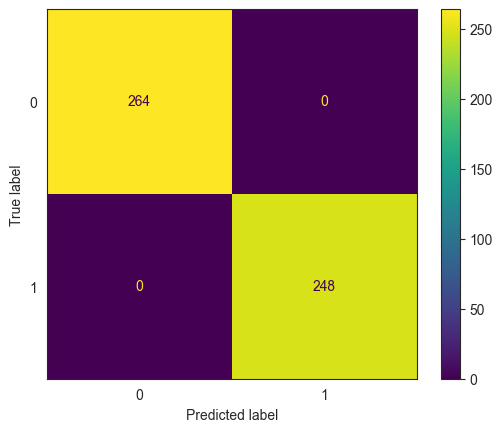

In [14]:
cm_S = confusion_matrix(syn2_test_t, syn2_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

Macierz pomyłek analityczna

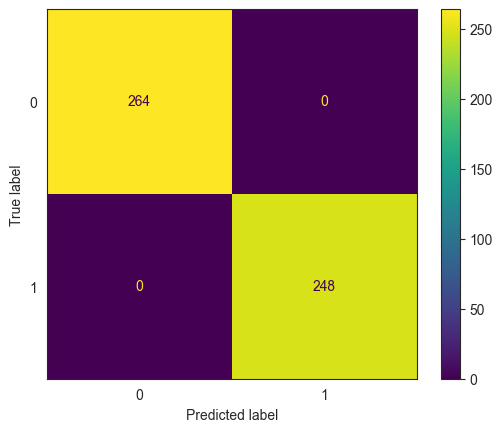

In [15]:
cm_A = confusion_matrix(syn2_test_t, syn2_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [16]:
TP = cm_S[1, 1]
FN = cm_S[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość sklearn {sensitivity:.2f}")

TP = cm_A[1, 1]
FN = cm_A[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość analityczna {sensitivity:.2f}")

TN = cm_S[0, 0]
FP = cm_S[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość sklearn {specificity:.2f}")

TN = cm_A[0, 0]
FP = cm_A[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość analityczna {specificity:.2f}")

Czułość sklearn 1.00
Czułość analityczna 1.00
Swoistość sklearn 1.00
Swoistość analityczna 1.00


Krzywa ROC sklearn

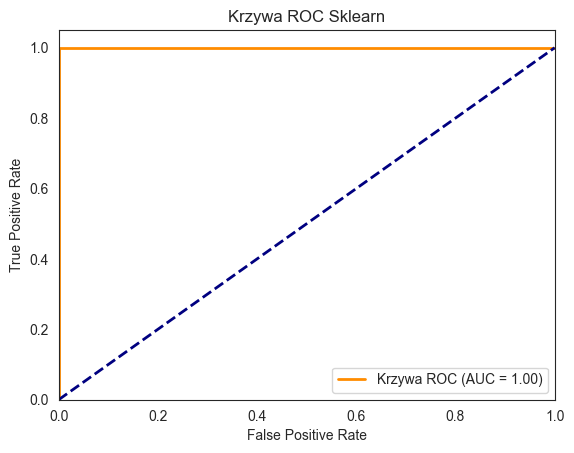

In [17]:
fpr, tpr, thresholds = roc_curve(syn2_test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC analityczna

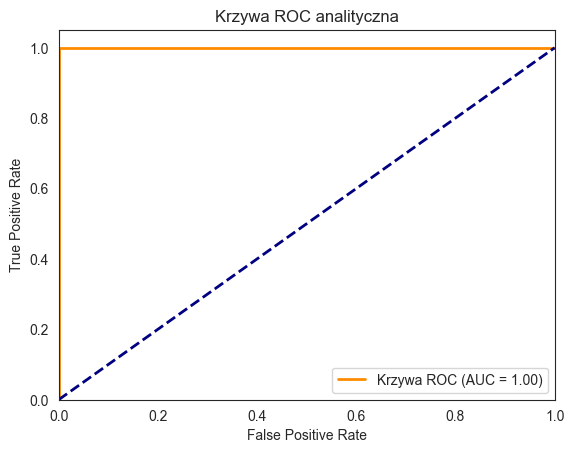

In [18]:
fpr, tpr, thresholds = roc_curve(syn2_test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC analityczna')
plt.legend(loc="lower right")
plt.show()

Zaimplementowana metoda analityczna oraz gotowe rozwiązanie Sklearn generują identyczne wyniki wykazując 100% poprawność klasyfiakcji .\
Dla przeprowadzonych 100 treningów wynik gotowego rozwiązania to 0.14766s natomiast rozwiązania analitycznego tylko 0.02849s

In [19]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
heart_data = pd.read_csv('HeartCleveland.csv', names=column_names, na_values=['?'])
heart_data.head()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Liczba brakujących wartości

In [20]:
heart_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fps         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

Usunięcie wierszy z brakami

In [21]:
heart_data.dropna(inplace=True)

podstawowe miary statystyczne

In [22]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


age - dyskretna \
sex - kategoryczna \
cp - kategoryczna \
trestbps - ciągła \
chol - ciągła \
fbs - dyskretna \
restecg - kategoryczna \
thalach - ciągła \
exang - dyskretna \
oldpeak - ciągła \
slope - kategoryczna \
ca - dyskretna \
thal - kategoryczna \
num - kategoryczna

Zamiana zmiennej przewidywanej na wartością binarną

In [23]:
heart_data.num.clip(upper=1, inplace=True)
heart_data.head()

C:\Users\marci\AppData\Local\Temp\ipykernel_31660\586649917.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data.num.clip(upper=1, inplace=True)


,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [24]:
continuous_vars = ['trestbps', 'chol', 'thalach', 'oldpeak']
heart_data[continuous_vars].describe()

,trestbps,chol,thalach,oldpeak
count,297.000000,297.000000,297.000000,297.000000
mean,131.693603,247.350168,149.599327,1.055556
std,17.762806,51.997583,22.941562,1.166123
min,94.000000,126.000000,71.000000,0.000000
25%,120.000000,211.000000,133.000000,0.000000
50%,130.000000,243.000000,153.000000,0.800000
75%,140.000000,276.000000,166.000000,1.600000
max,200.000000,564.000000,202.000000,6.200000


In [25]:
discrete_vars = ['age', 'ca']
heart_data[discrete_vars].describe()

,age,ca
count,297.000000,297.000000
mean,54.542088,0.676768
std,9.049736,0.938965
min,29.000000,0.000000
25%,48.000000,0.000000
50%,56.000000,0.000000
75%,61.000000,1.000000
max,77.000000,3.000000


In [26]:
categorical_vars = ['sex', 'cp', 'fps', 'restecg', 'exang', 'slope', 'thal']
df = heart_data[categorical_vars].describe().loc[['min', 'max']]
df

,sex,cp,fps,restecg,exang,slope,thal
min,0.0,1.0,0.0,0.0,0.0,1.0,3.0
max,1.0,4.0,1.0,2.0,1.0,3.0,7.0


Histogramy poszczególnych cech

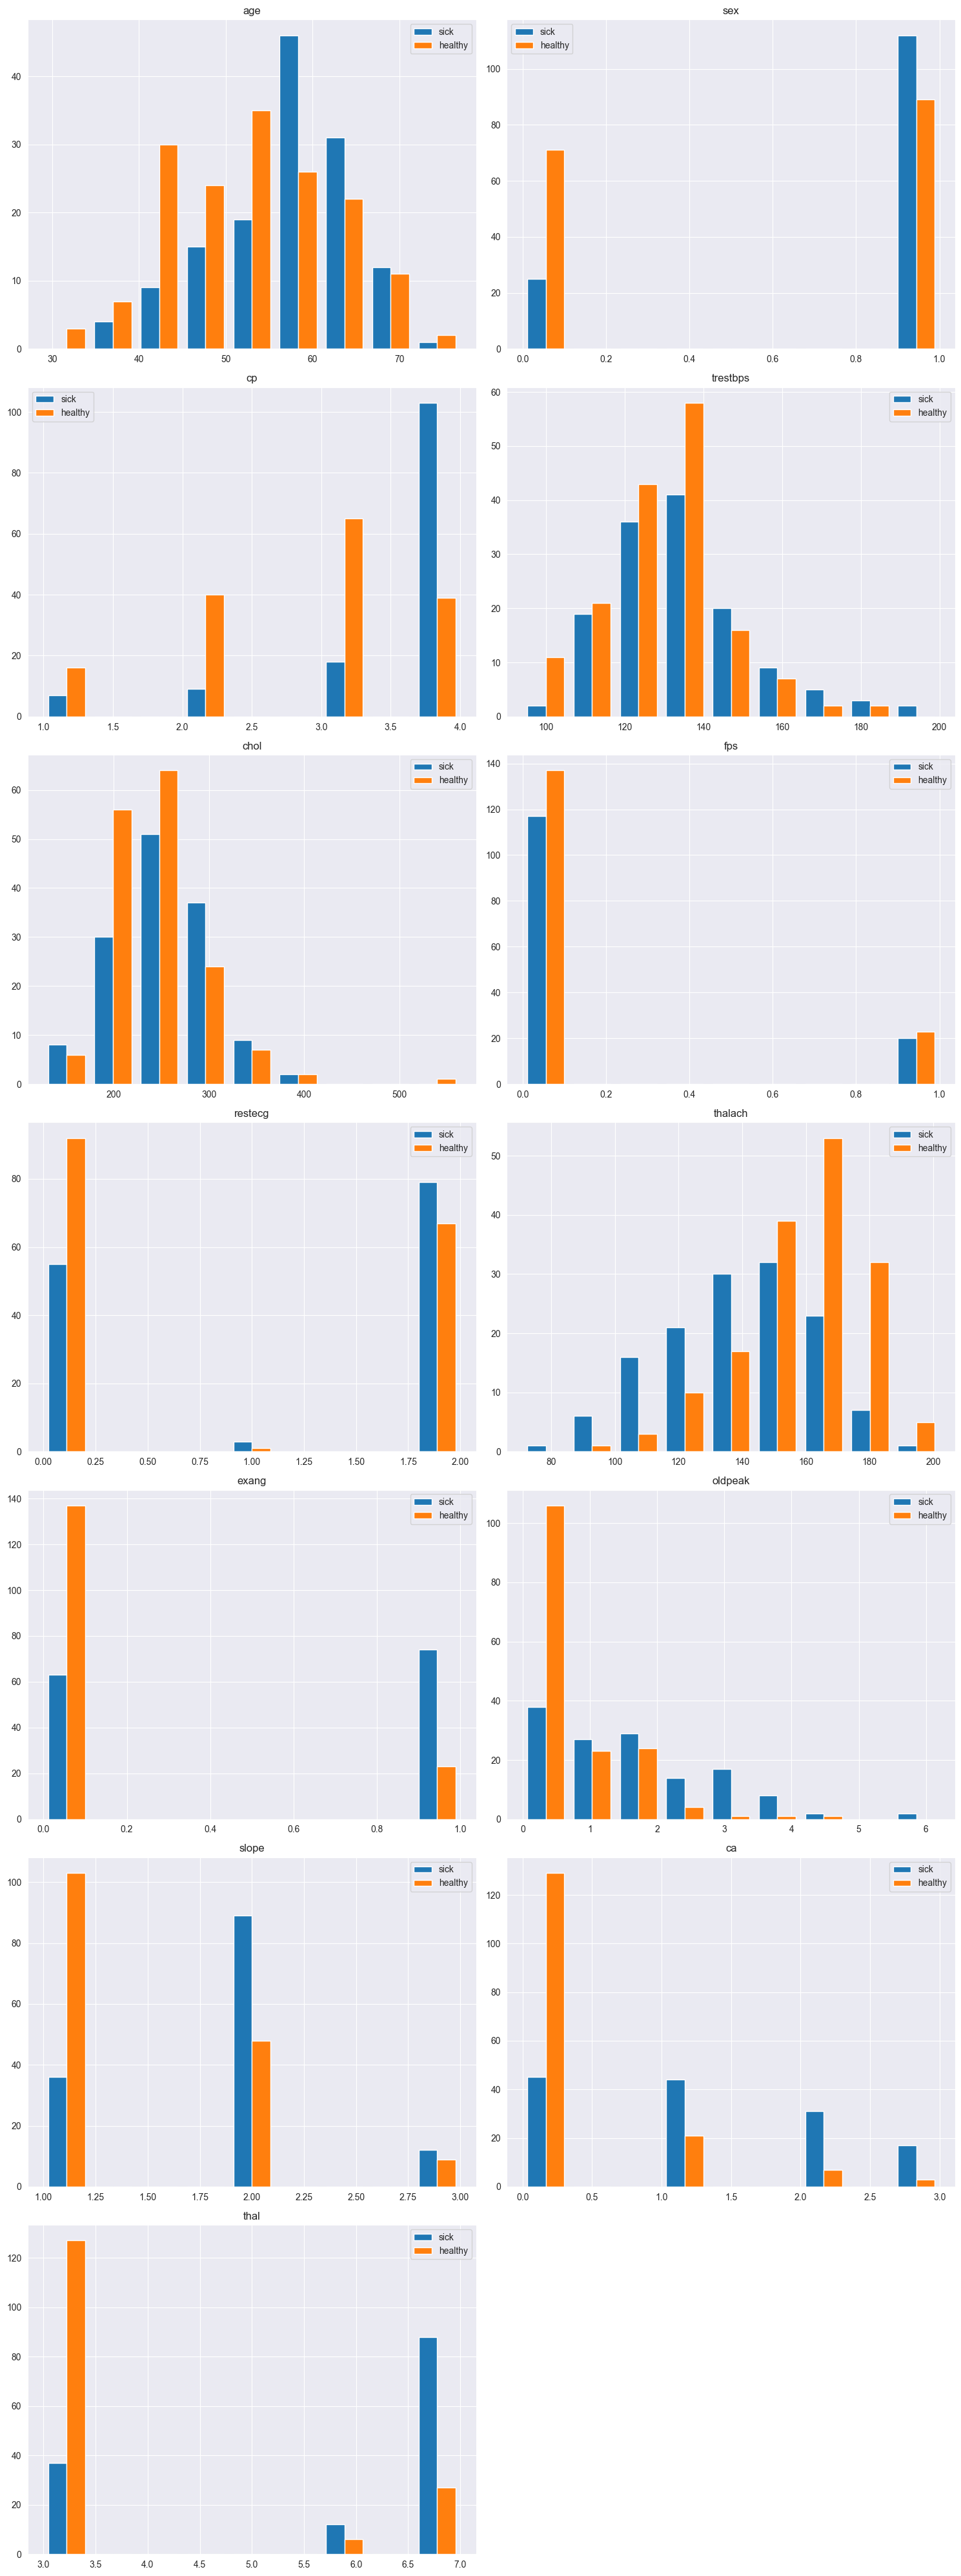

In [27]:
import seaborn as sns
features_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
sns.set_style("darkgrid")

heart_data_sick = heart_data.loc[heart_data['num'] == 1]
heart_data_healthy = heart_data.loc[heart_data['num'] == 0]
fig, axs = plt.subplots(7, 2, figsize=(15, 40))
fig.delaxes(axs[6, 1])


for i, feature in enumerate(features_names):
    ax = axs[i//2][i%2]
    maxx =max(heart_data_sick[feature].max(), heart_data_healthy[feature].max())
    minn = min(heart_data_sick[feature].min(), heart_data_healthy[feature].min())

    bins = np.linspace(minn, maxx, 10)
    ax.hist([heart_data_sick[feature], heart_data_healthy[feature]], bins, label=['sick', 'healthy'])
    ax.set_title(feature)
    ax.legend()

fig.tight_layout()

Tworzymy macierz korelacji

<Axes: >

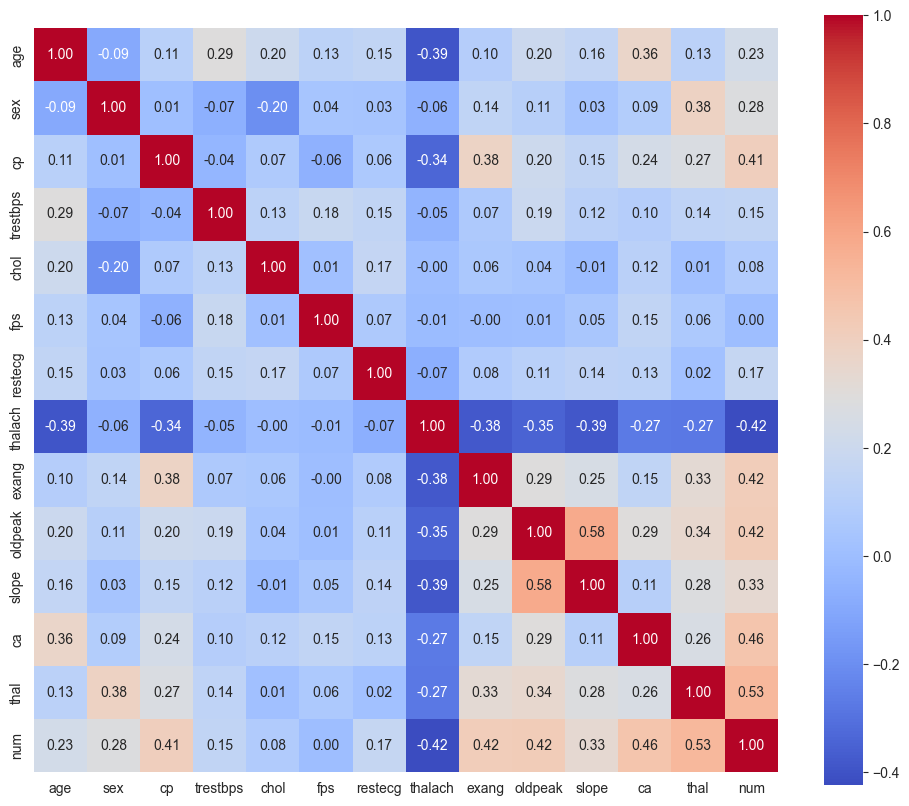

In [28]:
correlation_matrix = heart_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

Znajdujemy najlepsze cechy

In [29]:
biggest_corelations = correlation_matrix["num"].sort_values(key=abs, ascending=False)
print(biggest_corelations[:][1:5])

thal       0.526640
ca         0.463189
oldpeak    0.424052
thalach   -0.423817
Name: num, dtype: float64


Wybrane zostały akurat te cechy gdyż są one najsilniej skorelowane z wystąpieniem choroby zatem wykorzysatnie ich będzie najbardziej efektywne podczas uczenia modelu

In [30]:
train_x, test_x, train_t, test_t = train_test_split(heart_data.iloc[:, :-1], heart_data.iloc[:, -1], test_size=.2, random_state=seed)
train_t = train_t.values
test_t = test_t.values
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])
train_x = np.array(train_x)
test_x = np.array(test_x)

Klasyfikacji Sklearn (13 cech)

In [31]:
for _ in range(100):
    clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
end = time.time()
print(f"Czas obliczeń implementacji Sklearn 13 cech = {end - start}")
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

Czas obliczeń implementacji Sklearn 13 cech = 3.9166183471679688


Klasyfikacja analityczna (13 cech)

In [32]:
ALFA = 1.0


sns.set_style("white")
num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t

num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))

result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

Macierz pomyłek sklearn

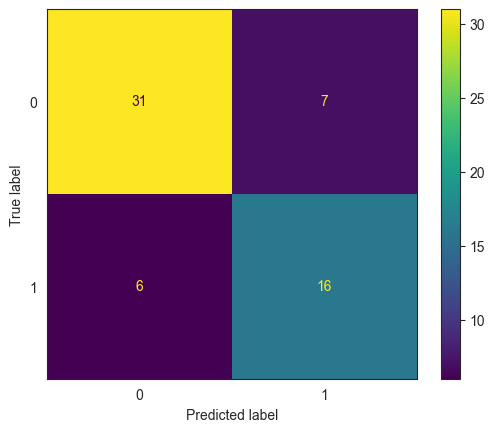

In [33]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

Macierz pomyłek analityczna

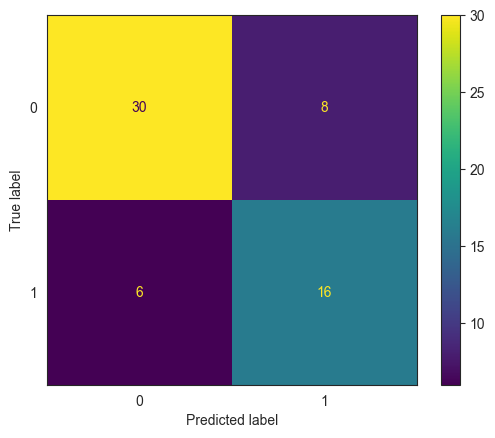

In [34]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [35]:
TP = cm_S[1, 1]
FN = cm_S[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość sklearn {sensitivity:.2f}")

TP = cm_A[1, 1]
FN = cm_A[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość analityczna {sensitivity:.2f}")

TN = cm_S[0, 0]
FP = cm_S[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość sklearn {specificity:.2f}")

TN = cm_A[0, 0]
FP = cm_A[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość analityczna {specificity:.2f}")

Czułość sklearn 0.73
Czułość analityczna 0.73
Swoistość sklearn 0.82
Swoistość analityczna 0.79


Krzywa ROC sklearn

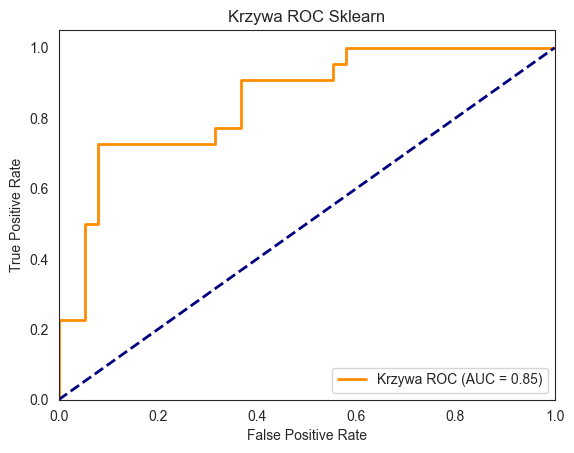

In [36]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC analityczna

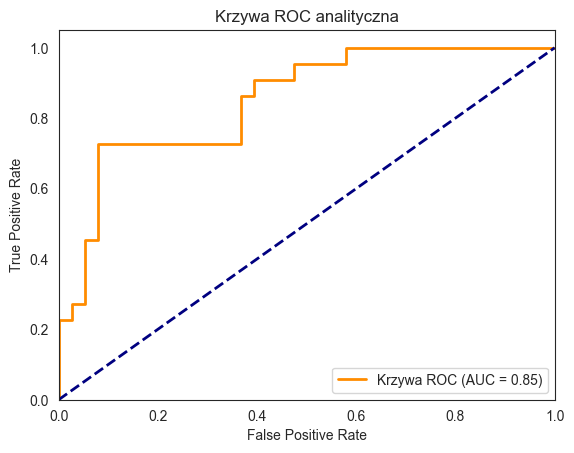

In [37]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC analityczna')
plt.legend(loc="lower right")
plt.show()

In [38]:
four_best = ["thal", "ca", "oldpeak", "thalach", "num"]
heart_data_four_np =  np.array(heart_data[four_best])
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])

Klasyfikacji Sklearn (4 recznie wybrane cechy)

In [39]:
start = time.time()
for _ in range(100):
    clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
end = time.time()
print(f"Czas obliczeń implementacji Sklearn 4 cechy = {end - start}")
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

Czas obliczeń implementacji Sklearn 4 cechy = 0.09916234016418457


Klasyfikacji analityczna (4 recznie wybrane cechy)

In [40]:
ALFA = 1.0

num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t
num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))
result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

Macierz pomyłek sklearn

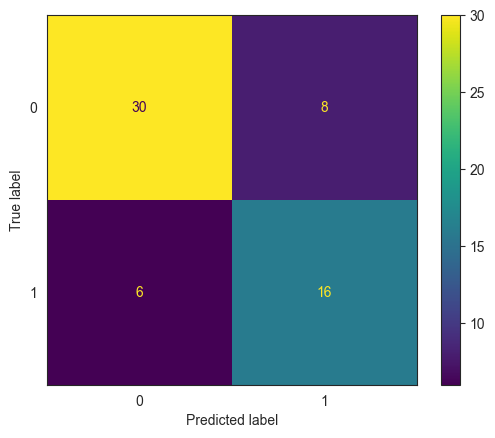

In [41]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

Macierz pomyłek analityczna

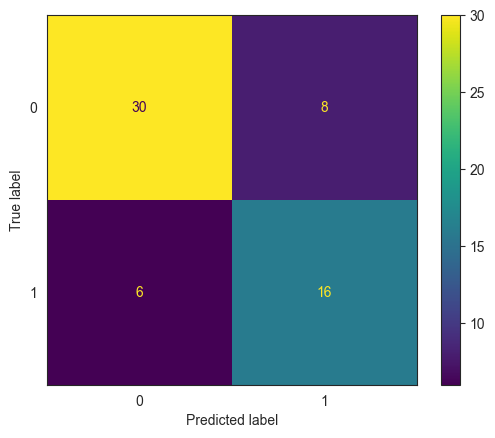

In [42]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [43]:
TP = cm_S[1, 1]
FN = cm_S[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość sklearn {sensitivity:.2f}")

TP = cm_A[1, 1]
FN = cm_A[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość analityczna {sensitivity:.2f}")

TN = cm_S[0, 0]
FP = cm_S[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość sklearn {specificity:.2f}")

TN = cm_A[0, 0]
FP = cm_A[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość analityczna {specificity:.2f}")

Czułość sklearn 0.73
Czułość analityczna 0.73
Swoistość sklearn 0.79
Swoistość analityczna 0.79


Krzywa ROC sklearn

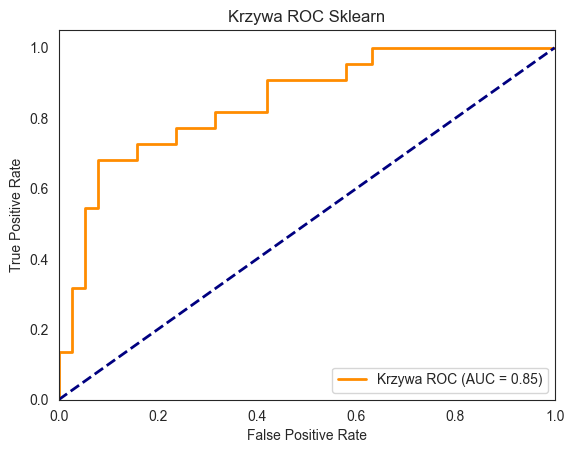

In [44]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC analityczna

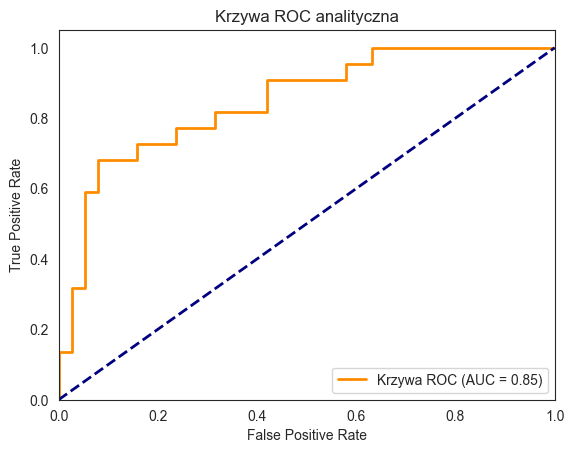

In [45]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC analityczna')
plt.legend(loc="lower right")
plt.show()

Zredukowanie liczby cech z 13 do 4 wybranych przyniosło znaczące oszczędności jeśli chodzi o czas wykonywania. 3.91661s -> 0.09916s\
Zmniejszenie ilości cech nie przyniosło negatywnego wpływu na wartości takie jak czułość czy swoistość.

Wybór najważniejszych 4 cech metodą SequentialFeatureSelector

In [46]:
heart_data_four_np =  np.array(heart_data)
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else t for t in train_t])
test_t = np.array([-1 if t == 0 else t for t in test_t])

In [47]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
column_names = np.array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

classifier = RidgeClassifier(alpha=1.0)
selector = SequentialFeatureSelector(classifier, n_features_to_select=4)
selector.fit(train_x, train_t)
print(column_names[selector.get_support()])

['restecg' 'oldpeak' 'ca' 'thal']


In [48]:
four_best = ["restecg", "oldpeak", "ca", "thal", "num"]
heart_data_four_np =  np.array(heart_data[four_best])
train_x, test_x, train_t, test_t = train_test_split(heart_data_four_np[:, :-1], heart_data_four_np[:, -1], test_size=.2, random_state=seed)
train_t = np.array([-1 if t == 0 else 1 for t in train_t])
test_t = np.array([-1 if t == 0 else 1 for t in test_t])

Klasyfikacji Sklearn

In [49]:
clf = RidgeClassifier(alpha=1.0).fit(train_x, train_t)
result_S = clf.decision_function(test_x)
syn_test_y_S =clf.predict(test_x)

Klasyfikacja analityczna

In [50]:
ALFA = 1.0

num_rows = train_x.shape[0]
ones_column = np.ones((num_rows, 1))
X = np.hstack((ones_column, train_x))
d = X.shape[1]
A = ALFA*np.identity(d)
teta_A = np.linalg.inv(X.T@X+A)@X.T@train_t
num_rows = test_x.shape[0]
ones_column = np.ones((num_rows, 1))
X_test = np.hstack((ones_column, test_x))
result_A = X_test@teta_A
syn1_test_y_A = np.array([-1 if res <= 0 else 1 for res in result_A])

Macierz pomyłek sklearn

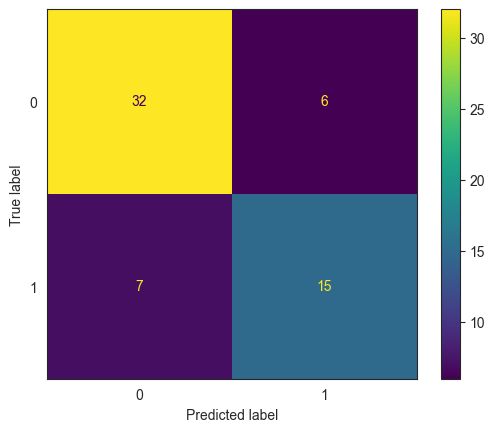

In [51]:
cm_S = confusion_matrix(test_t, syn_test_y_S)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

Macierz pomyłek analityczna

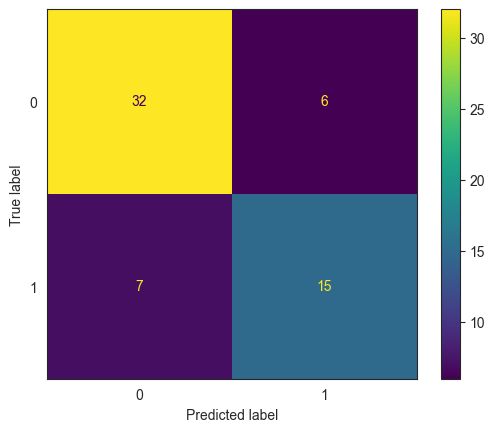

In [52]:
cm_A = confusion_matrix(test_t, syn1_test_y_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_A)
disp.plot()
plt.show()

In [53]:
TP = cm_S[1, 1]
FN = cm_S[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość sklearn {sensitivity:.2f}")

TP = cm_A[1, 1]
FN = cm_A[1, 0]
sensitivity = TP / (TP + FN)
print(f"Czułość analityczna {sensitivity:.2f}")

TN = cm_S[0, 0]
FP = cm_S[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość sklearn {specificity:.2f}")

TN = cm_A[0, 0]
FP = cm_A[0, 1]
specificity = TN / (TN + FP)
print(f"Swoistość analityczna {specificity:.2f}")

Czułość sklearn 0.68
Czułość analityczna 0.68
Swoistość sklearn 0.84
Swoistość analityczna 0.84


Krzywa ROC sklearn

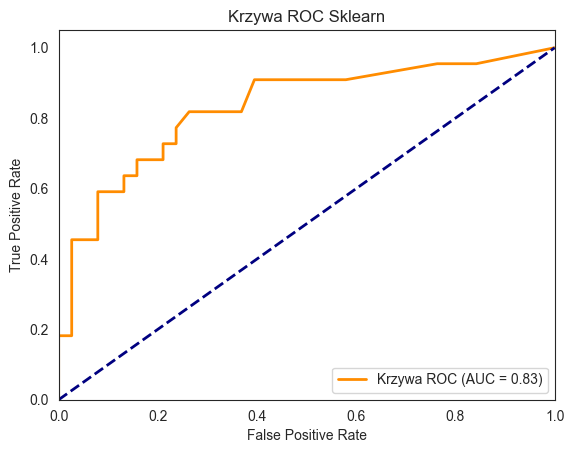

In [54]:
fpr, tpr, thresholds = roc_curve(test_t, result_S)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

Krzywa ROC analityczna

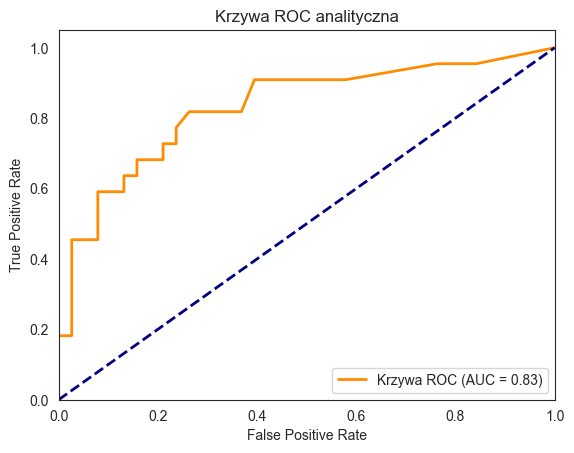

In [55]:
fpr, tpr, thresholds = roc_curve(test_t, result_A)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC analityczna')
plt.legend(loc="lower right")
plt.show()

Wykorzystanie metody SequentialFeatureSelector skutkowało wybraniem podobnych cech jednak zamiast cechy 'thalach' została wybrana 'restecg'. Skutkiem tej zmiany czułość lekko się pogorszyła na rzecz swoistości.